In [3]:
import pandas as pd
import numpy as np
import pyreadr
import itables
# from matplotlib import pyplot as plt
# import stanza
from bill_law_similarity.string_diff import show_diffs,diff
from bill_law_similarity.clean import clean_text_ger, clean_law_aut, clean_bill_aut
import polars as pl
from polars import col
# import seaborn as sns

# reload imports
%load_ext autoreload
%autoreload 2

# Data

In [4]:
def get_df(path):
    df = pyreadr.read_r(path)[None]
    return pl.from_pandas(df)


def load_data(country):
    bills = get_df(f"data/{country}/Corpus_bills_{country}.RDS")
    laws = get_df(f"data/{country}/Corpus_laws_{country}.RDS")
    if country == "austria":
        bills = bills.rename({"date": "initiation_date"}).with_columns(
            [col("period").cast(pl.Int32)]
        )

    if country == "germany":
        bills = bills.with_columns(
            [col("initiation_date").str.strptime(pl.Date, "%d.%m.%Y")]
        )
    data = bills.join(
        laws, on="speech_procedure_ID", how="inner", suffix="_law"
    ).filter(col("law_text").is_not_null() & col("bill_text").is_not_null())
    data = data.sort("initiation_date", descending=False)
    return data


def clean_data(data, bill_fn, law_fn):
    data = (
        data.select(
            [
                col("bill_text").apply(bill_fn),
                col("law_text").apply(law_fn),
            ]
        )
        .filter(
            col("bill_text").is_not_null()
            & col("law_text").is_not_null()
        )
        .filter(
            col("bill_text").str.contains("Artikel")
            & col("law_text").str.contains("Artikel")
        )
    )
    return data


In [5]:
data_aut = clean_data(load_data("austria"), clean_bill_aut, clean_law_aut)
#data_ger = clean_data(load_data("germany"), clean_text_ger, clean_text_ger)

In [13]:
data_aut["law_text"][0].split("Artikel")[1]

' 1 Änderung des Allgemeinen Sozialversicherungsgesetzes (61. Novelle zum ASVG) Teil 1 Das Allgemeine Sozialversicherungsgesetz, BGBl. Nr. 189/1955, zuletzt geändert durch das Bun-desgesetz BGBl. I Nr. 71/2003, wird wie folgt geändert: 1. Im § 5 Abs. 1 Z 3 lit. b wird der Ausdruck „Versicherungsanstalt der österreichischen Eisenbahnen“ durch den Ausdruck „Versicherungsanstalt für Eisenbahnen und Bergbau“ ersetzt.2. Im § 7 Z 3 lit. b wird nach dem Ausdruck „Österreichischen Bundesbahnen“ der Ausdruck „oder von Unternehmen im Sinne des § 1 des ÖBB-Dienstrechtsgesetzes“ eingefügt und der Ausdruck „nach der Bundesbahn-Pensionsordnung 1966, BGBl. Nr. 313“ durch den Ausdruck „und nach dem Bundesbahn-Pensionsgesetz“ ersetzt.3. § 7 Z 4 lit. d lautet: „d) die Bediensteten der Versicherungsanstalt öffentlich Bediensteter; “ 4. Im § 8 Abs. 1 Z 3 lit. g wird der Ausdruck „sowie der Tierärztekammern“ durch den Ausdruck „ , des Tiroler Skilehrerverbandes, der Tierärztekammer“ ersetzt.6. Im § 15 Abs.

In [ ]:
i = 4
a = data_ger["bill_text"][i]
b = data_ger["bill_text_c"][i]
show_diffs(a,b, timeout=50)

# Cosine Similarity

In [4]:
import re   
import string
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances

In [5]:
from tqdm import tqdm


nlp = spacy.load("de_core_news_sm", disable=["tok2vec", "tagger", "morphologizer", "parser", "lemmatizer", "senter", "attribute_ruler", "ner"])
nlp.max_length = 100000000

def tokenize(text_column, position=0):
    docs = nlp.pipe(text_column, disable=["tagger", "parser", "lemmatizer"])
    doc_tokens = []
    for doc in tqdm(docs, total=len(text_column), position=position):
        tokens = []
        for token in doc:
            if token.text.strip(string.punctuation) != "":
                tokens.append(token.text)
        doc_tokens.append(tokens)
    return pl.Series(doc_tokens)

def fit_vectorize(df):
    cv = TfidfVectorizer( norm="l2", use_idf=False, token_pattern=None, lowercase=False, tokenizer=lambda x: x)
    cv.fit(df["bill_text_tokens"])
    cv.fit(df["law_text_tokens"])
    return cv
    
def vectorize(text_column, cv):
    print("Fitted vectorizer")
    token_matrix = cv.transform(text_column)
    print("Transformed")
    return token_matrix

def compute_distances(law_vectors, bill_vectors):
    return paired_cosine_distances(law_vectors, bill_vectors) 

In [5]:
data_tokenized = pl.read_json("data/austria/data_tokenized.csv")
# data_tokenized = data_aut.select([
#     col("bill_text").map(tokenize).alias("bill_text_tokens"),
#     col("law_text").map(lambda x: tokenize(x, 1)).alias("law_text_tokens"),
# ])
#data_tokenized.write_json("data/austria/data_tokenized.csv")

In [87]:
cv = fit_vectorize(data_tokenized)
bill_vectors = vectorize(data_tokenized["bill_text_tokens"], cv)
law_vectors = vectorize(data_tokenized["law_text_tokens"], cv)

Fitted vectorizer
Transformed
Fitted vectorizer
Transformed


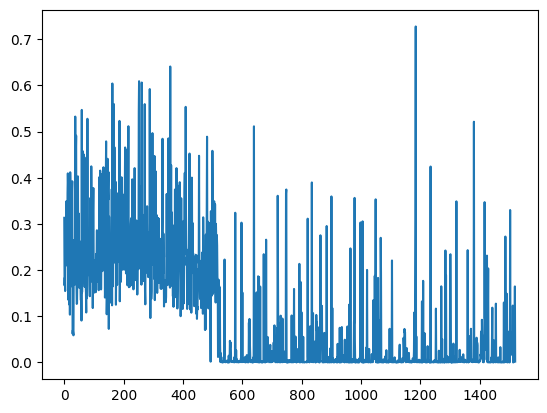

In [106]:
import matplotlib.pyplot as plt
plt.plot(compute_distances(law_vectors, bill_vectors))

In [ ]:
law_tokens_ger, bill_tokens_ger = vectorize_bill_law(data_ger)
distances_ger = compute_distances(data_ger, law_tokens_ger, bill_tokens_ger)

Fitted vectorizer
Transformed law
Transformed bill


In [90]:
distances_aut = data_aut.with_columns([
   pl.Series(name="cosine" ,values= paired_cosine_distances(law_vectors, bill_vectors)),])

# DocuToads

In [7]:
from bill_law_similarity.docu_toads import docu_toads_similarity
# dynamic imports
%load_ext autoreload
%autoreload 2

a = data_tokenized["bill_text_tokens"][-1].to_list()
b = data_tokenized["law_text_tokens"][-1].to_list()

docu_toads_similarity(a,b)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.8890679953106683

In [8]:
k  = data_tokenized.sample(5).with_columns([
    pl.struct([pl.col("bill_text_tokens"), pl.col("law_text_tokens")]).apply(lambda x_dict: docu_toads_similarity(x_dict["bill_text_tokens"],x_dict["law_text_tokens"])).alias("docu_toads")
])


In [23]:
k

[autoreload of polars.datatypes.classes failed: Traceback (most recent call last):
  File "/home/peter/anaconda3/envs/bill-law/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/peter/anaconda3/envs/bill-law/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/peter/anaconda3/envs/bill-law/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/peter/anaconda3/envs/bill-law/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/home/peter/anaconda3/envs/bill-law/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to DataTypeClass object
]
[autore

bill_text_tokens,law_text_tokens,docu_toads
list[str],list[str],f64
"["" "", ""Bundesgesetz"", … ""vorgeschlagen""]","["" "", ""Inhaltsverzeichnis"", … ""Bierlein""]",0.673836
"["" "", ""Das"", … ""“""]","["" "", ""Das"", … ""Löger""]",0.986239
"["" "", ""Inhaltsverzeichnis"", … ""“""]","["" "", ""Inhaltsverzeichnis"", … ""Kern""]",0.976879
"["" "", ""Artikel"", … ""findet""]","["" "", ""Artikel"", … ""GMBH""]",0.123111
"["" "", ""Inhaltsverzeichnis"", … ""“""]","["" "", ""Inhaltsverzeichnis"", … ""Gusenbauer""]",0.948466


In [14]:
def bow_overlap(s1, s2):
    set1 = set(s1)
    set2 = set(s2)
    overlap = set1.intersection(set2)
    return len(overlap) / len(set1.union(set2))
    
k  = data_tokenized.sample(5).with_columns([
    pl.struct([pl.col("bill_text_tokens"), pl.col("law_text_tokens")]).apply(lambda x_dict: bow_overlap(x_dict["bill_text_tokens"],x_dict["law_text_tokens"])).alias("docu_toads")
])

In [ ]:
!https://github.com/hikoseon12/learning-bill-similarity/tree/main/data/subsection_pairs/human_annotated_pairs

In [22]:
!wget -O test.csv https://github.com/hikoseon12/learning-bill-similarity/raw/main/data/subsection_pairs/human_annotated_pairs/test_sub_sec_pairs.csv 

--2023-04-24 20:11:55--  https://github.com/hikoseon12/learning-bill-similarity/raw/main/data/subsection_pairs/human_annotated_pairs/test_sub_sec_pairs.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hikoseon12/learning-bill-similarity/main/data/subsection_pairs/human_annotated_pairs/test_sub_sec_pairs.csv [following]
--2023-04-24 20:11:56--  https://raw.githubusercontent.com/hikoseon12/learning-bill-similarity/main/data/subsection_pairs/human_annotated_pairs/test_sub_sec_pairs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2242926 (2.1M) [text/plain]
Saving to: ‘test.csv’

test.csv    

In [15]:
k

bill_text_tokens,law_text_tokens,docu_toads
list[str],list[str],f64
"["" "", ""Bundesgesetz"", … ""vorgeschlagen""]","["" "", ""Inhaltsverzeichnis"", … ""Bierlein""]",0.673836
"["" "", ""Das"", … ""“""]","["" "", ""Das"", … ""Löger""]",0.986239
"["" "", ""Inhaltsverzeichnis"", … ""“""]","["" "", ""Inhaltsverzeichnis"", … ""Kern""]",0.976879
"["" "", ""Artikel"", … ""findet""]","["" "", ""Artikel"", … ""GMBH""]",0.123111
"["" "", ""Inhaltsverzeichnis"", … ""“""]","["" "", ""Inhaltsverzeichnis"", … ""Gusenbauer""]",0.948466


In [124]:
matrix.shape

(6369, 6825)

In [116]:
coutput = collections.Counter(list(zip(*output[0]))[2])

In [118]:
coutput

Counter({'match': 6093,
         'deletion': 109,
         'substitution': 159,
         'addition': 565,
         'transposition': 7})

In [122]:
penalties = {
    "match": 0,
    "addition": 2,
    "deletion": 2,
    "substitution": 1,
    "transposition": 1,
}
result = {'match': 6093,
         'deletion': 109,
         'substitution': 159,
         'addition': 565,
         'transposition': 7}

total = sum([penalties[k]*v for k,v in result.items()])
normalized = 1-(total / max(len_a, len_b))
normalized

0.7781359906213364

In [11]:
bt =  backtrace_writer(output[0], a, b)
names = bt.pop(0)

NameError: name 'backtrace_writer' is not defined

In [73]:
pl.from_records(bt, orient="row", schema=names)

Text 1 index,Text 2 index,Edit operation,Removed or substituted word,Added or substituted word,Word in both texts
i64,i64,str,str,str,str
1,1,"""""","""""","""""",""" """
2,2,"""substitution""","""Inhaltsverzeic…","""Artikel""",""""""
3,3,"""substitution""","""§""","""1""",""""""
4,4,"""substitution""","""1.""","""Änderung""",""""""
5,5,"""substitution""","""Führung""","""des""",""""""
6,6,"""substitution""","""der""","""Allgemeinen""",""""""
7,7,"""substitution""","""Europa‑Wählere…","""Sozialversiche…",""""""
8,8,"""substitution""","""1""","""61.""",""""""
9,9,"""substitution""","""§""","""Novelle""",""""""


In [36]:
coutput

Counter({'addition': 4, 'match': 4, 'substitution': 1, 'deletion': 4})

In [22]:
list(zip(*output[0]))[2]

('match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'transposition',
 'transposition',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match',
 'match')

In [14]:
import collections
coutput = collections.Counter(list(zip(*output[0])[2]))

TypeError: 'zip' object is not subscriptable

In [98]:
def plot_distance(data):
    data["initiation_date"] = pd.to_datetime(data["initiation_date"])
    data["year"] = data_aut["initiation_date"].dt.year
    data.groupby("year")[["cosine"]].mean().plot()
    
# rewrite in polars
def plot_distance(data):
    time = data.select(["cosine","initiation_date"]).with_columns([
        col("initiation_date").dt.year().alias("year"),
    ])
    return time.groupby("year").agg([pl.mean("cosine")]).sort("year")

Text(0.5, 1.0, 'Cosine distance between bill and law')

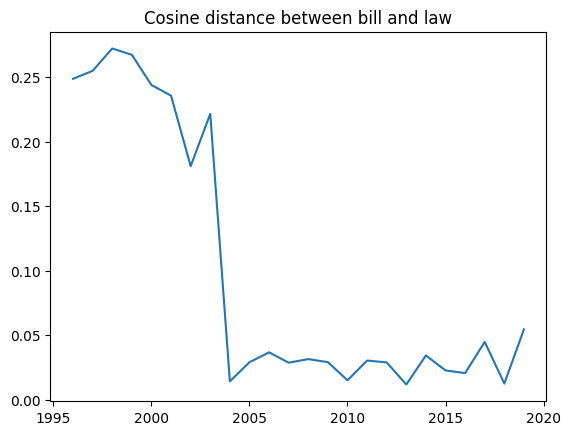

In [107]:
distance_agg_aut = plot_distance(distances_aut)
plt.plot(distance_agg_aut["year"], distance_agg_aut["cosine"], label= "Austrian")
plt.title("Cosine distance between bill and law")

<function matplotlib.pyplot.legend(*args, **kwargs)>

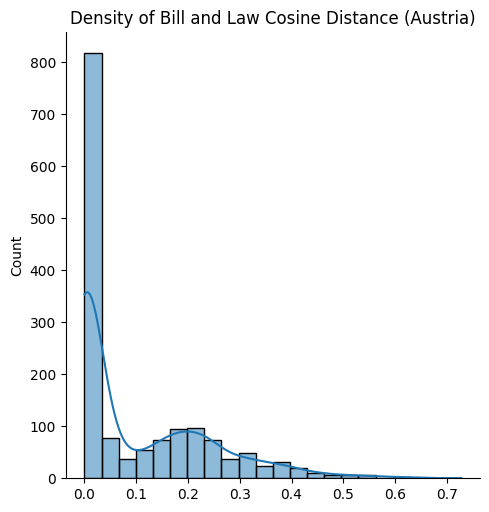

In [108]:
import seaborn as sns
sns.displot(distances_aut["cosine"], label="Austrian", multiple="stack", kde=True)
plt.title("Cosine distance between bill and law")
plt.title("Density of Bill and Law Cosine Distance (Austria)")

# y scale 0 to 1

plt.legend

Text with multiple spaces, tabs, `\r` and `\n` eliminated

## Statistics

In [112]:
def compute_lengths(df):
    return df.select([
        col("law_text").str.n_chars().alias("length_bill"),
        col("bill_text").str.n_chars().alias("length_law")
    ])#.filter((col("length_bill") - col("length_law")).abs() < 70000)

We have a weirdly high amount of bills with length 126320. Interestingly, laws are shorter than bills

In [113]:
length_bill_law_aut = compute_lengths(data_aut)
# length_bill_law_ger = compute_lengths(data_ger)

In [114]:
# mode
length_bill_law_aut.mean()

length_bill,length_law
f64,f64
73780.107237,63494.138816


In [56]:
length_bill_law_ger.mean()

length_bill,length_law
f64,f64
40423.390029,193864.253666


In [115]:

def plot_length(df, country):
    sns.regplot(x=df.select("length_bill"),y= df.select("length_law"), scatter_kws={"alpha":0.5, "s": 4})
    # add title
    # plot diagonal
    #sns.lineplot(x=[0, length_bill_law_aut.max().select("length_bill").item()], y=[0, length_bill_law_aut.max().select("length_law").item()], color="#333333")
    plt.title('Bill vs Law length (characters) in ' + country)
    # plot diagonal
    plt.axline((0, 0), (1, 1), linewidth=1, color='#333333', alpha=0.5)

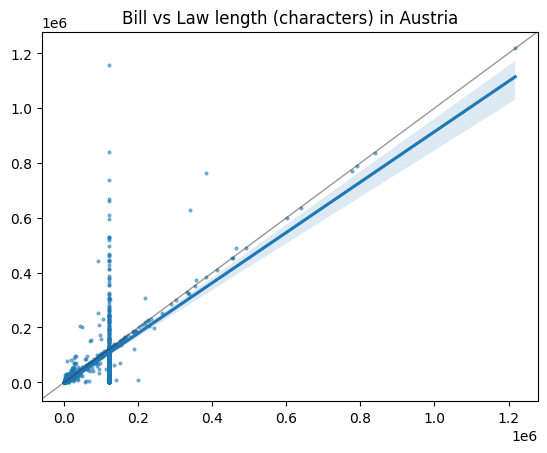

In [116]:
plot_length(length_bill_law_aut, "Austria")
plt.show()
# plot_length(length_bill_law_ger, "Germany")